### Importaciones

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage import io, color, exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler

In [90]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

### Rutas y Visualizar Conteo de Imagenes

In [4]:
base_dir = 'C:/Users/HOME/Downloads/Proyecto ML/Proyecto'
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')
images_dir = os.path.join(base_dir, 'HAM10000_images')

In [6]:
contenido = os.listdir(images_dir)
print(f"Número total de archivos en {images_dir}: {len(contenido)}")

Número total de archivos en C:/Users/HOME/Downloads/Proyecto ML/Proyecto\HAM10000_images: 10015


### Creacion del DataFrame - Analisis

In [7]:
df = pd.read_csv(metadata_path)

In [8]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


#### Visualizar Valores Nulos

In [10]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [11]:
df = df.dropna()
df.isnull().sum()


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [12]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


#### Eliminar Columnas y/o Filas no Relevantes

In [13]:
df = df.drop(columns=['lesion_id', 'dx_type'])


In [14]:
df

,image_id,dx,age,sex,localization
0,ISIC_0027419,bkl,80.0,male,scalp
1,ISIC_0025030,bkl,80.0,male,scalp
2,ISIC_0026769,bkl,80.0,male,scalp
3,ISIC_0025661,bkl,80.0,male,scalp
4,ISIC_0031633,bkl,75.0,male,ear
...,...,...,...,...,...
10010,ISIC_0033084,akiec,40.0,male,abdomen
10011,ISIC_0033550,akiec,40.0,male,abdomen
10012,ISIC_0033536,akiec,40.0,male,abdomen
10013,ISIC_0032854,akiec,80.0,male,face


C:\Users\HOME\AppData\Local\Temp\ipykernel_18476\4235744734.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='dx', order=df['dx'].value_counts().index, palette='Set2')


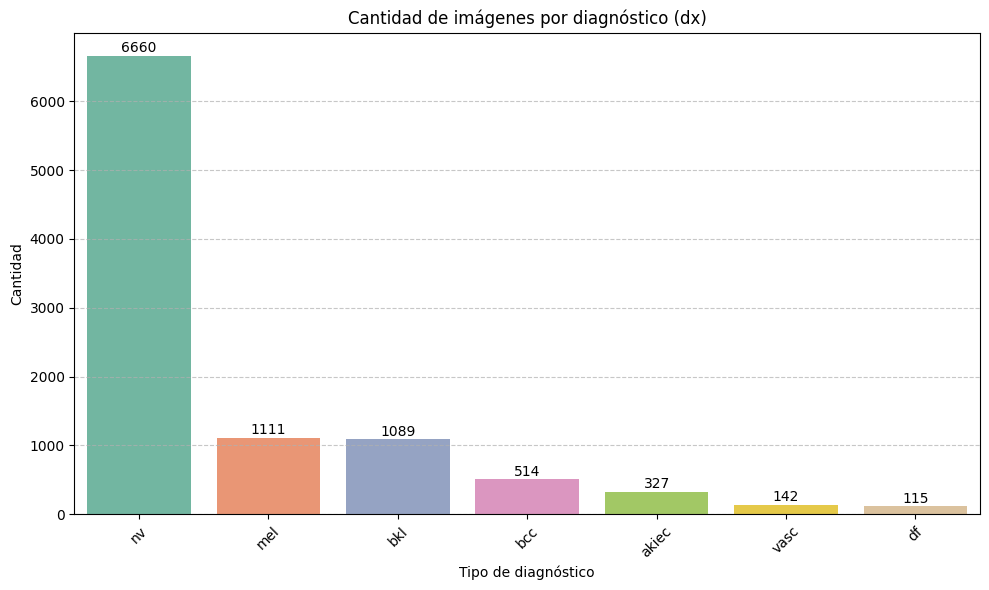

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='dx', order=df['dx'].value_counts().index, palette='Set2')

# Título y etiquetas
plt.title('Cantidad de imágenes por diagnóstico (dx)')
plt.xlabel('Tipo de diagnóstico')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores sobre cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 50, int(height), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
df = df[~df['dx'].isin(['vasc', 'df'])]

In [19]:
print(df['dx'].value_counts())

dx
nv       6660
mel      1111
bkl      1089
bcc       514
akiec     327
Name: count, dtype: int64


In [26]:
df[df['age'] < 18]['dx'].value_counts()

dx
nv     223
bkl      6
mel      1
Name: count, dtype: int64

In [52]:
df['sex'].unique()

array(['male', 'female', 'unknown'], dtype=object)

In [53]:
df[df['sex'] == 'unknown']['dx'].value_counts()

dx
nv    10
Name: count, dtype: int64

#### Balancear clases 

In [54]:
# Filtrar edades mayores o iguales a 18 y eliminar registros con sex 'unknown'
df_filtrado = df[(df['age'] >= 18) & (df['sex'] != 'unknown')]

# Balancear tomando máximo 300 por clase
df_base = df_filtrado.groupby('dx', group_keys=False).apply(lambda x: x.sample(n=300, random_state=42)).reset_index(drop=True)

C:\Users\HOME\AppData\Local\Temp\ipykernel_18476\3170597260.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_base = df_filtrado.groupby('dx', group_keys=False).apply(lambda x: x.sample(n=300, random_state=42)).reset_index(drop=True)


In [55]:
df_base['dx'].value_counts()

dx
akiec    300
bcc      300
bkl      300
mel      300
nv       300
Name: count, dtype: int64

In [56]:
df_base

,image_id,dx,age,sex,localization
0,ISIC_0024646,akiec,70.0,female,face
1,ISIC_0027753,akiec,70.0,male,upper extremity
2,ISIC_0032404,akiec,70.0,male,face
3,ISIC_0029041,akiec,80.0,male,scalp
4,ISIC_0030491,akiec,80.0,male,scalp
...,...,...,...,...,...
1495,ISIC_0032472,nv,45.0,female,abdomen
1496,ISIC_0031572,nv,45.0,female,abdomen
1497,ISIC_0028446,nv,45.0,male,lower extremity
1498,ISIC_0028917,nv,65.0,female,lower extremity


In [57]:
for col in df_base.columns:
    print(f"--- {col} ---")
    print(df_base[col].unique())
    print()


--- image_id ---
['ISIC_0024646' 'ISIC_0027753' 'ISIC_0032404' ... 'ISIC_0028446'
 'ISIC_0028917' 'ISIC_0030589']

--- dx ---
['akiec' 'bcc' 'bkl' 'mel' 'nv']

--- age ---
[70. 80. 65. 60. 85. 75. 55. 45. 50. 40. 25. 30. 35. 20.]

--- sex ---
['female' 'male']

--- localization ---
['face' 'upper extremity' 'scalp' 'back' 'lower extremity' 'trunk' 'neck'
 'hand' 'abdomen' 'chest' 'ear' 'unknown' 'foot' 'genital']



In [58]:
df_base.to_csv('df_balanceado.csv', index=False)

#### Convertir Imagenes a Calor

In [59]:
output_dir = os.path.join(base_dir, 'Imagenes_Calor')

# Crear carpeta de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Función para generar imagen de calor
def generar_mapa_calor(image_id):
    ruta_img = os.path.join(images_dir, image_id + '.jpg')

    # Leer imagen
    img = cv2.imread(ruta_img)
    if img is None:
        print(f"No se pudo leer {ruta_img}")
        return
    img = cv2.resize(img, (224, 224))

    # Escala de grises y aplicar colormap
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    heatmap = cv2.applyColorMap(gray, cv2.COLORMAP_JET)

    # Superponer
    superpuesto = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Guardar
    salida = os.path.join(output_dir, image_id + '.jpg')
    cv2.imwrite(salida, superpuesto)

# Aplicar a todas las imágenes de df_base
for img_id in tqdm(df_base['image_id']):
    generar_mapa_calor(img_id)

100%|██████████| 1500/1500 [00:06<00:00, 230.93it/s]


#### Estandarizar columnas categóricas

In [61]:
dx_map = dict(enumerate(pd.Categorical(df_base['dx']).categories))
sex_map = dict(enumerate(pd.Categorical(df_base['sex']).categories))
loc_map = dict(enumerate(pd.Categorical(df_base['localization']).categories))

print("dx:", dx_map)
print("sex:", sex_map)
print("localization:", loc_map)


dx: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'mel', 4: 'nv'}
sex: {0: 'female', 1: 'male'}
localization: {0: 'abdomen', 1: 'back', 2: 'chest', 3: 'ear', 4: 'face', 5: 'foot', 6: 'genital', 7: 'hand', 8: 'lower extremity', 9: 'neck', 10: 'scalp', 11: 'trunk', 12: 'unknown', 13: 'upper extremity'}


In [62]:
# Convertir valores categóricos a números desde 0
df_base['dx'] = pd.Categorical(df_base['dx']).codes
df_base['sex'] = pd.Categorical(df_base['sex']).codes
df_base['localization'] = pd.Categorical(df_base['localization']).codes

In [63]:
df_base

,image_id,dx,age,sex,localization
0,ISIC_0024646,0,70.0,0,4
1,ISIC_0027753,0,70.0,1,13
2,ISIC_0032404,0,70.0,1,4
3,ISIC_0029041,0,80.0,1,10
4,ISIC_0030491,0,80.0,1,10
...,...,...,...,...,...
1495,ISIC_0032472,4,45.0,0,0
1496,ISIC_0031572,4,45.0,0,0
1497,ISIC_0028446,4,45.0,1,8
1498,ISIC_0028917,4,65.0,0,8


In [64]:
df_base.to_csv('df_entrenamiento.csv', index=False)

### Entrenamiento CNN + Tabular

#### Cargar datos e imágenes

In [69]:
images_train = os.path.join(base_dir, 'Imagenes_Calor')

img_size = (224, 224)
def cargar_imagen(image_id):
    path = os.path.join(images_train, image_id + '.jpg')
    img = load_img(path, target_size=img_size)
    return img_to_array(img) / 255.0

X_img = np.array([cargar_imagen(img_id) for img_id in df_base['image_id']])
X_tab = df_base[['age', 'sex', 'localization']].values
y = to_categorical(df_base['dx'])

#### Dividir datos en entrenamiento y validación

In [70]:
X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img, X_tab, y, test_size=0.2, stratify=df_base['dx'], random_state=42
)

#### Definir y compilar modelo CNN + Tabular

In [75]:
# Entrada imagen
img_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Entrada tabular
tab_input = Input(shape=(X_tab.shape[1],))
x_tab = Dense(32, activation='relu')(tab_input)

# Fusión
combined = Concatenate()([x, x_tab])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(y.shape[1], activation='softmax')(z)

# Compilar modelo
model = Model(inputs=[img_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

#### Entrenar el modelo

In [76]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.2064 - loss: 5.6659 - val_accuracy: 0.3500 - val_loss: 1.4751
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.2982 - loss: 1.5935 - val_accuracy: 0.3233 - val_loss: 1.4588
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.3715 - loss: 1.4274 - val_accuracy: 0.3800 - val_loss: 1.4210
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.3396 - loss: 1.4231 - val_accuracy: 0.3767 - val_loss: 1.3742
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.3827 - loss: 1.3664 - val_accuracy: 0.4067 - val_loss: 1.3489
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.3776 - loss: 1.3526 - val_accuracy: 0.3800 - val_loss: 1.3840
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.3789 - loss: 1.3477 - val_accuracy: 0.4000 - val_loss: 1.3432
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.4210 - loss: 1.3167 - val_accuracy: 0.

#### Graficar curvas de entrenamiento

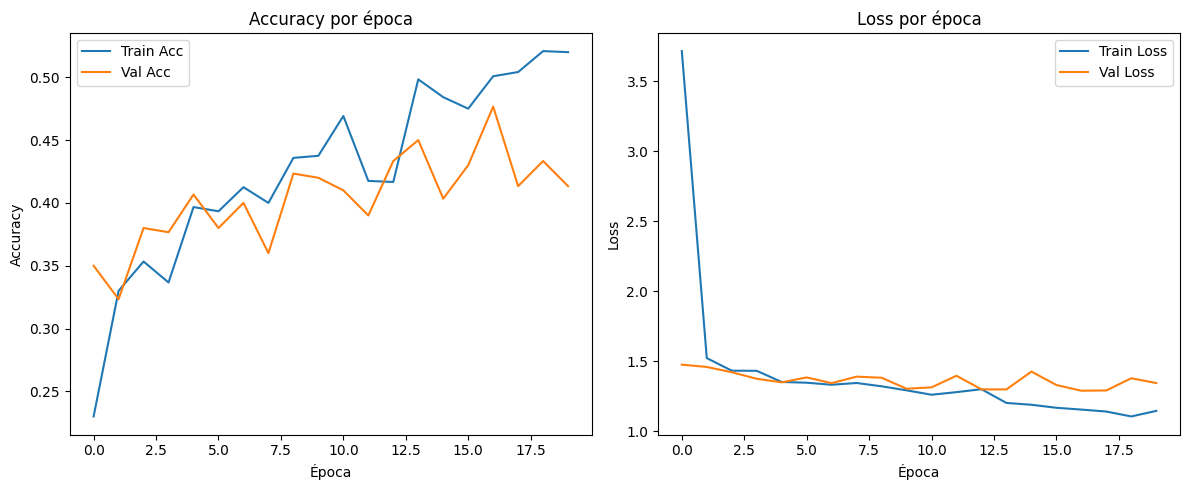

In [77]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy por época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluar el modelo (F1, Precision, Recall, ROC)

In [80]:
# Predicciones
y_pred_probs = model.predict([X_img_val, X_tab_val])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# ROC AUC Score macro
roc_auc_macro = roc_auc_score(y_val, y_pred_probs, average='macro', multi_class='ovr')
print(f"ROC AUC (macro promedio): {roc_auc_macro:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.68      0.57        60
           1       0.37      0.17      0.23        60
           2       0.39      0.45      0.42        60
           3       0.43      0.60      0.50        60
           4       0.78      0.48      0.60        60

    accuracy                           0.48       300
   macro avg       0.49      0.48      0.46       300
weighted avg       0.49      0.48      0.46       300

ROC AUC (macro promedio): 0.7764


#### Graficar curvas ROC por clase

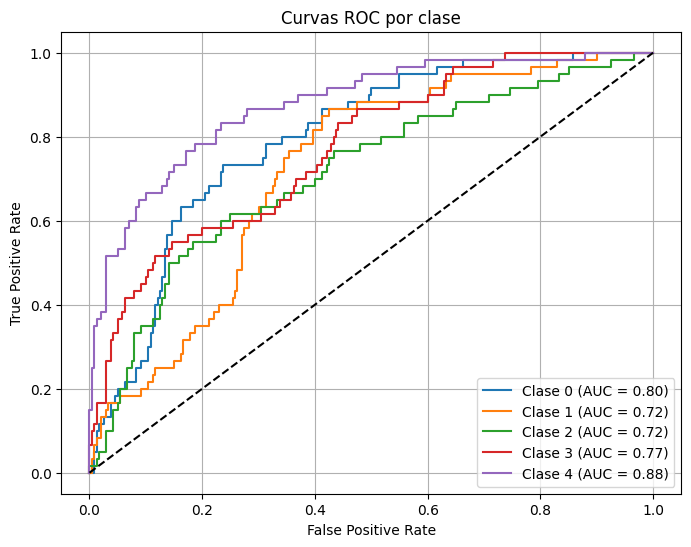

In [81]:
n_classes = y.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC por clase')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

#### Guardar el modelo entrenado en .keras

In [82]:
model.save('modelo_entrenado_v1.keras')


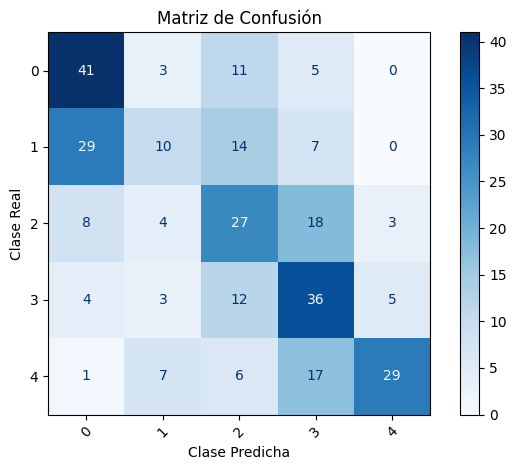

In [85]:
# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Matriz de Confusión")
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.tight_layout()
plt.show()

### Entrenamiento Transfer Learning + Tabulares (FineTuning en base a Resultados)

#### Fase Inicial

##### Cargar datos e imágenes (con Data Augmentation)

In [93]:
images_dir = os.path.join(base_dir, 'Imagenes_Calor')
aug_dir = os.path.join(base_dir, 'IMG_AUG')
os.makedirs(aug_dir, exist_ok=True)

# Cargar DataFrame base
df_base = pd.read_csv(os.path.join(base_dir, 'df_entrenamiento.csv'))

# Data Augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear nuevas imágenes aumentadas + DataFrame extendido
aug_rows = []
for i, row in tqdm(df_base.iterrows(), total=len(df_base)):
    image_id = row['image_id']
    path_img = os.path.join(images_dir, image_id + '.jpg')
    
    if not os.path.exists(path_img):
        continue
    
    # Cargar imagen original
    img = cv2.imread(path_img)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.

    # Guardar original en carpeta nueva
    new_filename = f'{image_id}_orig.jpg'
    cv2.imwrite(os.path.join(aug_dir, new_filename), (img * 255).astype(np.uint8))
    aug_rows.append({**row, 'image_id': image_id + '_orig'})

    # Generar 3 aumentos por imagen
    img = img.reshape((1, 224, 224, 3))
    aug_iter = datagen.flow(img, batch_size=1)
    for j in range(3):
        aug_img = next(aug_iter)[0]
        aug_filename = f'{image_id}_aug{j}.jpg'
        cv2.imwrite(os.path.join(aug_dir, aug_filename), (aug_img * 255).astype(np.uint8))
        aug_rows.append({**row, 'image_id': image_id + f'_aug{j}'})

# Nuevo DataFrame con datos aumentados
df_entrenar = pd.DataFrame(aug_rows)

100%|██████████| 1500/1500 [00:21<00:00, 71.10it/s]


##### Dividir datos en entrenamiento y validación

In [101]:
X_img = []
X_tab = []
y = []

for _, row in df_entrenar.iterrows():
    path_img = os.path.join(aug_dir, row['image_id'] + '.jpg')
    
    if not os.path.exists(path_img):
        continue

    # Cargar y escalar imagen
    img = cv2.imread(path_img)
    img = cv2.resize(img, (224, 224))
    X_img.append(img / 255.)

    # Variables tabulares
    X_tab.append([row['age'], row['sex'], row['localization']])

    # Etiqueta
    y.append(row['dx'])

# Convertir a arrays
X_img = np.array(X_img)
X_tab = np.array(X_tab)
y = to_categorical(pd.factorize(y)[0])  # One-hot encoding

C:\Users\HOME\AppData\Local\Temp\ipykernel_18476\2349279919.py:25: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  y = to_categorical(pd.factorize(y)[0])  # One-hot encoding


In [102]:
X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img, X_tab, y, test_size=0.2, stratify=np.argmax(y, axis=1), random_state=42
)

##### Definir y compilar modelo CNN + Tabular con Transfer Learning

In [ ]:
# Imagen (EfficientNet)
img_input = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=img_input)
x_img = GlobalAveragePooling2D()(base_model.output)

# Tabular
tab_input = Input(shape=(X_tab_train.shape[1],))
x_tab = Dense(32, activation='relu')(tab_input)

# Fusión
x = Concatenate()([x_img, x_tab])
x = Dropout(0.5)(x)
output = Dense(y.shape[1], activation='softmax')(x)

# Modelo final
model = Model(inputs=[img_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

##### Entrenar el modelo

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=32,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.2658 - loss: 3.1515 - val_accuracy: 0.2000 - val_loss: 2.3220
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.5495 - loss: 1.4868 - val_accuracy: 0.2108 - val_loss: 1.8904
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 998ms/step - accuracy: 0.6387 - loss: 1.0502 - val_accuracy: 0.2533 - val_loss: 1.9884
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 149s 996ms/step - accuracy: 0.7333 - loss: 0.7382 - val_accuracy: 0.4175 - val_loss: 1.5604
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.8283 - loss: 0.4923 - val_accuracy: 0.4608 - val_loss: 1.7380
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.8743 - loss: 0.3543 - val_accuracy: 0.2908 - val_loss: 2.5833
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9136 - loss: 0.2405 - val_accuracy: 0.3750 - val_loss: 2.5166


##### Graficar curvas de entrenamiento

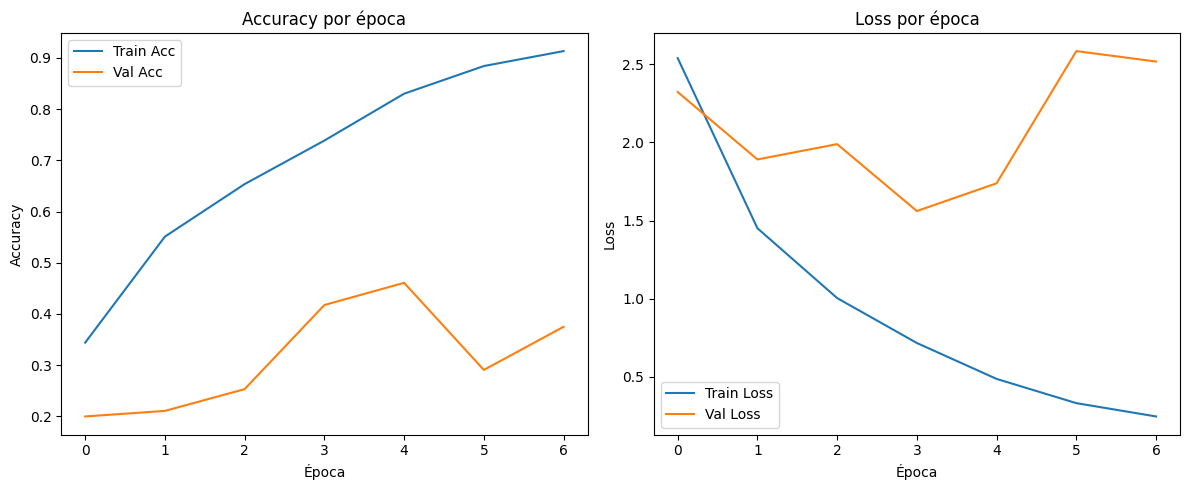

In [105]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy por época')
plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss por época')
plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

##### Evaluar el modelo (F1, Precision, Recall, ROC)

In [106]:
y_pred_probs = model.predict([X_img_val, X_tab_val])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

roc_auc_macro = roc_auc_score(y_val, y_pred_probs, average='macro', multi_class='ovr')
print(f"ROC AUC (macro promedio): {roc_auc_macro:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.40      0.42       240
           1       0.55      0.33      0.42       240
           2       0.44      0.26      0.33       240
           3       0.79      0.28      0.41       240
           4       0.32      0.82      0.46       240

    accuracy                           0.42      1200
   macro avg       0.51      0.42      0.41      1200
weighted avg       0.51      0.42      0.41      1200

ROC AUC (macro promedio): 0.7429


##### Graficar curvas ROC por clase

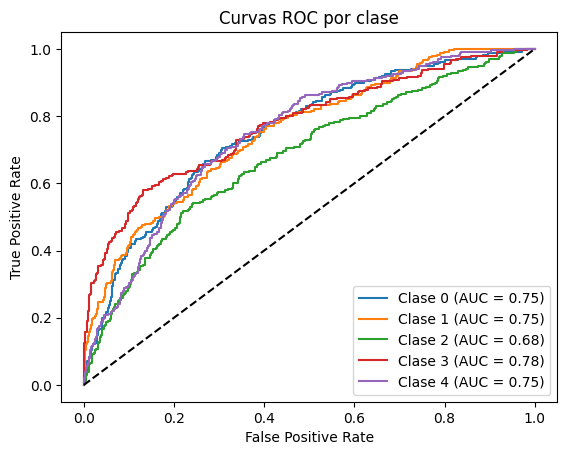

In [107]:
plt.figure()
for i in range(y.shape[1]):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC por clase')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### Guardar el modelo entrenado en .keras

In [108]:
model.save('modelo_transfer.keras')

#### Fine-tuning (descongelar capas superiores de EfficientNetB0)

In [ ]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8115 - loss: 0.5159 - val_accuracy: 0.6375 - val_loss: 1.1123
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8238 - loss: 0.5046 - val_accuracy: 0.7750 - val_loss: 0.6187
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8024 - loss: 0.5383 - val_accuracy: 0.7925 - val_loss: 0.5857
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8167 - loss: 0.4978 - val_accuracy: 0.8092 - val_loss: 0.5452
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8151 - loss: 0.5175 - val_accuracy: 0.8017 - val_loss: 0.5689
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8077 - loss: 0.5372 - val_accuracy: 0.8033 - val_loss: 0.5630
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8166 - loss: 0.5099 - val_accuracy: 0.8050 - val_loss: 0.5568


##### Grafica del FineTuning por Epocas

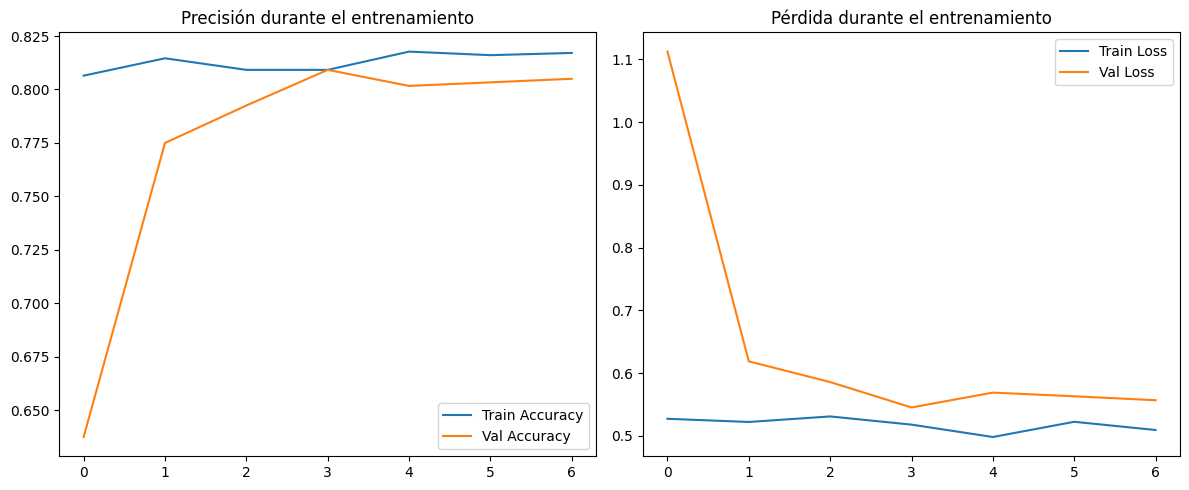

In [ ]:
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Precisión durante el entrenamiento')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Pérdida durante el entrenamiento')

plt.tight_layout()
plt.show()


##### Grafico de la Curva ROC en base a las Clases

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step


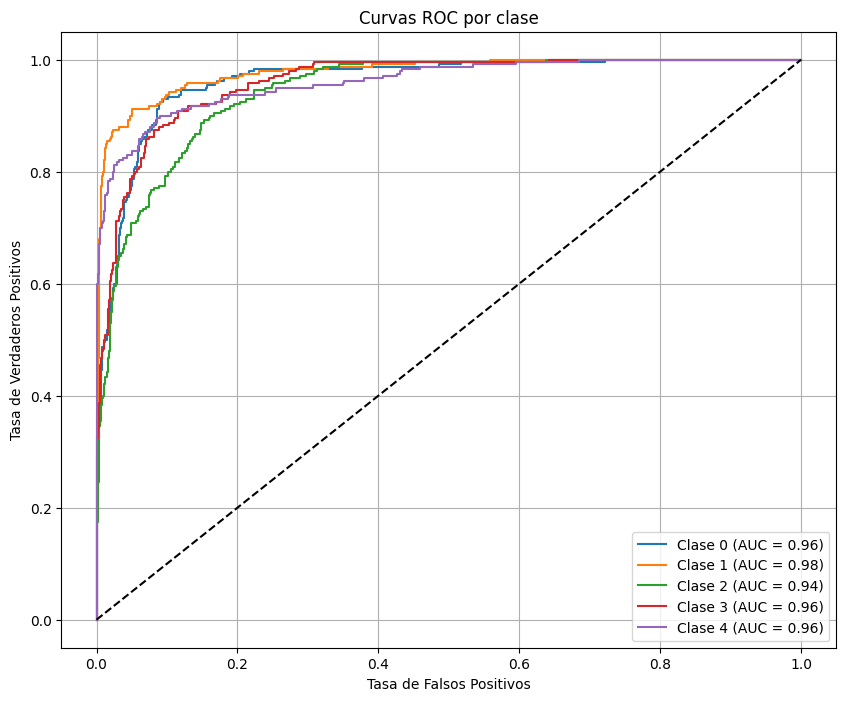

In [112]:
# Predecir probabilidades
y_pred_prob = model.predict([X_img_val, X_tab_val])

# ROC por clase
n_classes = y_val.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##### Evalular las predicciones del modelo (Precision, Recall, F1-score)

In [ ]:
y_pred_prob = model.predict([X_img_val, X_tab_val])
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_val, axis=1)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print("Classification Report:\n")
print(report)


38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       240
           1       0.92      0.85      0.88       240
           2       0.73      0.75      0.74       240
           3       0.79      0.78      0.78       240
           4       0.85      0.82      0.83       240

    accuracy                           0.81      1200
   macro avg       0.81      0.81      0.81      1200
weighted avg       0.81      0.81      0.81      1200



##### Matriz de confusion sobre la Prediccion

<Figure size 800x600 with 0 Axes>

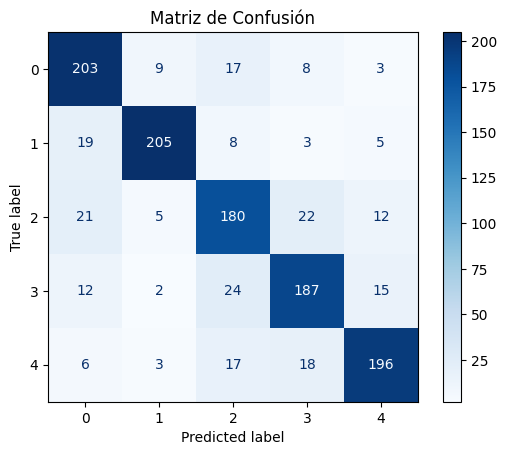

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión")
plt.show()

##### Guardar Modelo Mejorado

In [119]:
model.save('modelo_transfer_tuned.keras')

### Resultado de la Grafico del Proceso Completo

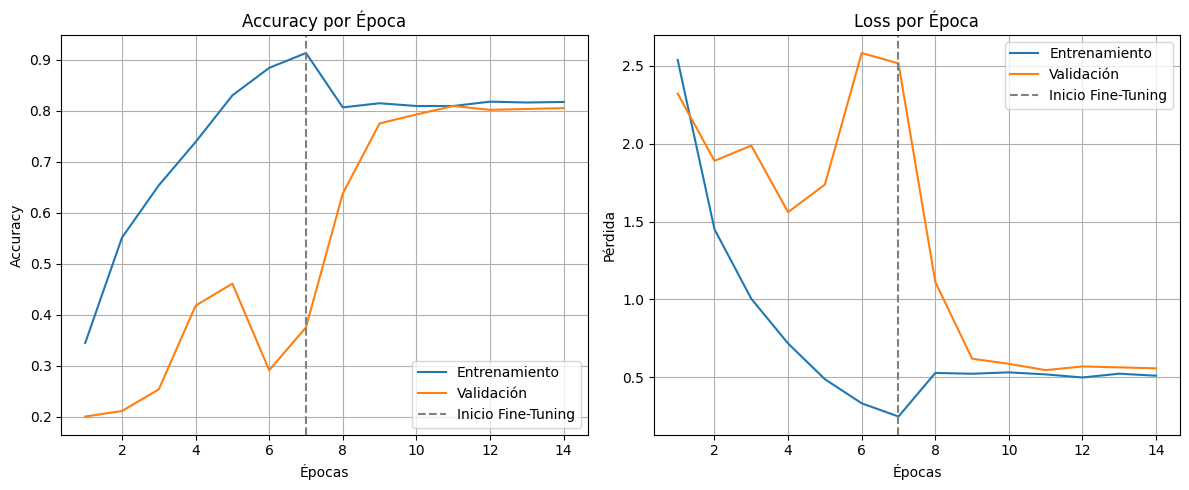

In [ ]:
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']

loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

epochs = range(1, len(acc) + 1)

# Gráfico Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Entrenamiento')
plt.plot(epochs, val_acc, label='Validación')
plt.axvline(x=len(history.history['accuracy']), color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Accuracy por Época')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Gráfico Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Entrenamiento')
plt.plot(epochs, val_loss, label='Validación')
plt.axvline(x=len(history.history['accuracy']), color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Loss por Época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()